Daily data saved to July_daily.csv
Processed 7 investment dates.
Total Invested: $700.00
Total BTC Bought: 0.00653260
Final Value at 2025-07-18: $780.71
Return on Investment: 11.53%

Purchase History:
        Date  BTC_Bought          Price  Total_Invested  Final_Value  \
0 2025-06-01    0.000956  104646.463194             100   114.203423   
1 2025-06-08    0.000945  105795.920833             200   227.166042   
2 2025-06-15    0.000949  105393.451389             300   340.560036   
3 2025-06-22    0.000987  101326.425694             400   458.505421   
4 2025-06-29    0.000929  107690.979861             500   569.480215   
5 2025-07-06    0.000922  108456.222222             600   679.671996   
6 2025-07-13    0.000845  118282.252083             700   780.709845   

         ROI  
0  11.529978  
1  11.529978  
2  11.529978  
3  11.529978  
4  11.529978  
5  11.529978  
6  11.529978  
DCA results saved to dca_results.csv


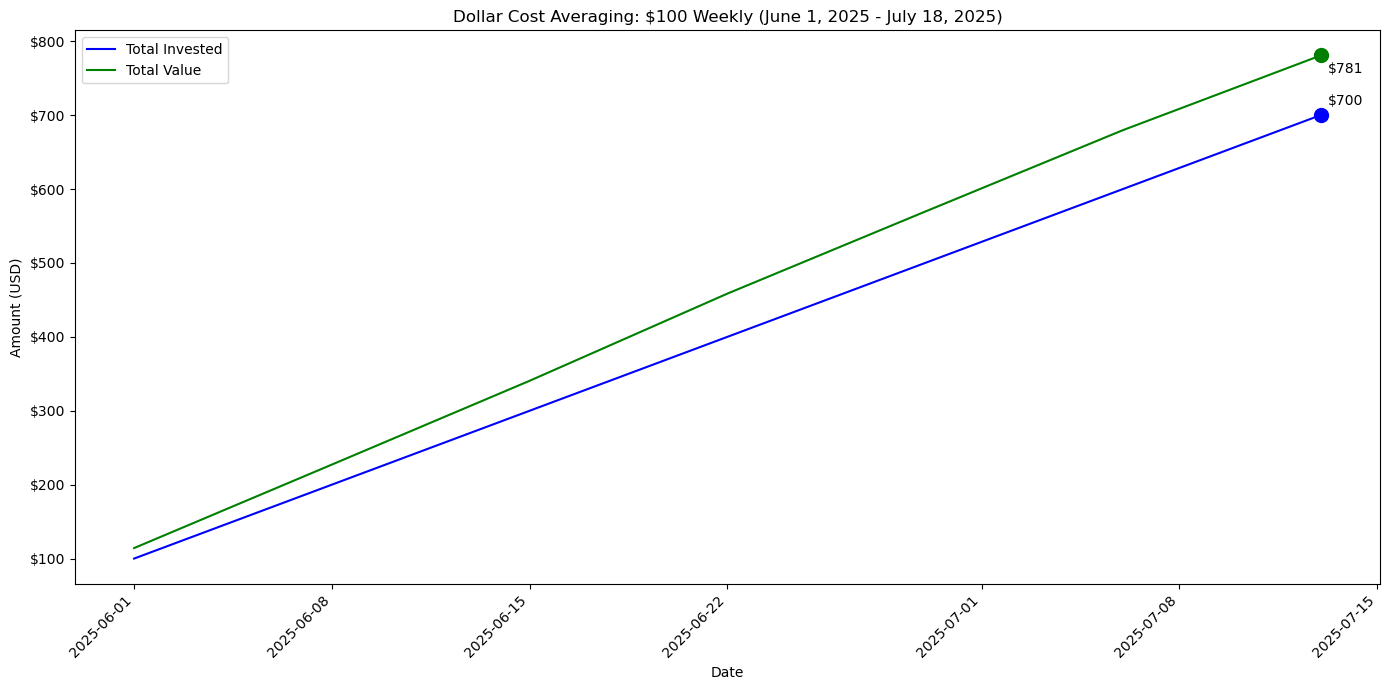

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pathlib import Path

def convert_to_daily(df):
    """Convert minute-by-minute Bitcoin data to daily aggregates."""
    try:
        required_columns = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
        if not all(col in df.columns for col in required_columns):
            raise ValueError(f"Missing required columns: {required_columns}")
        
        # Convert Unix timestamp to datetime (no timezone for simplicity)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
        # Check for missing or invalid values
        if df[required_columns[1:]].isna().any().any():
            print("Warning: Missing values detected. Filling with forward-fill.")
            df = df.ffill()
        # Aggregate to daily data
        df = df.set_index('Timestamp')
        daily_df = df.resample('D').agg({
            'Open': 'mean',
            'High': 'mean',
            'Low': 'mean',
            'Close': 'mean',
            'Volume': 'sum'
        }).reset_index()
        # Ensure no missing dates
        date_range = pd.date_range(start=daily_df['Timestamp'].min(), end=daily_df['Timestamp'].max(), freq='D')
        daily_df = daily_df.set_index('Timestamp').reindex(date_range).ffill().reset_index()
        daily_df.rename(columns={'index': 'Timestamp'}, inplace=True)
        return daily_df
    except Exception as e:
        raise Exception(f"Error in convert_to_daily: {str(e)}")

def calculate_dca(df, investment_amount, frequency_days, start_date, end_date):
    """Simulate Dollar Cost Averaging strategy."""
    try:
        # Validate inputs
        if investment_amount <= 0:
            raise ValueError("Investment amount must be positive.")
        if frequency_days <= 0:
            raise ValueError("Frequency days must be positive.")
        start_date = pd.to_datetime(start_date).replace(tzinfo=None)
        end_date = pd.to_datetime(end_date).replace(tzinfo=None)
        if start_date > end_date:
            raise ValueError("Start date must be before end date.")
        
        # Ensure Timestamp is datetime without timezone
        df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.tz_localize(None)
        # Validate date range
        if df['Timestamp'].min() > start_date:
            raise ValueError(f"Dataset starts at {df['Timestamp'].min()}, after start_date {start_date}")
        if df['Timestamp'].max() < end_date:
            print(f"Warning: Dataset ends at {df['Timestamp'].max()}, before end_date {end_date}. Using last available date.")
            end_date = df['Timestamp'].max()
        
        # Generate investment dates
        investment_dates = pd.date_range(start=start_date, end=end_date, freq=f'{frequency_days}D')
        purchases = []
        total_invested = 0
        total_btc = 0
        
        for invest_date in investment_dates:
            invest_date = invest_date.replace(tzinfo=None)
            # Find closest date in data before or on invest_date
            valid_rows = df[df['Timestamp'] <= invest_date]
            if valid_rows.empty:
                raise ValueError(f"No data available before or on {invest_date}")
            price_row = valid_rows.iloc[-1]
            price = price_row['Close']
            if price <= 0:
                raise ValueError(f"Invalid price ({price}) on {price_row['Timestamp']}")
            btc_bought = investment_amount / price
            total_invested += investment_amount
            total_btc += btc_bought
            purchases.append({
                'Date': invest_date,
                'BTC_Bought': btc_bought,
                'Price': price,
                'Total_Invested': total_invested,
                'Total_BTC': total_btc
            })
        
        # Find final price (closest date on or before end_date)
        final_row = df[df['Timestamp'] <= end_date].iloc[-1]
        final_price = final_row['Close']
        final_value = total_btc * final_price
        roi = (final_value - total_invested) / total_invested * 100 if total_invested > 0 else 0
        
        purchases_df = pd.DataFrame(purchases)
        if purchases_df.empty:
            raise ValueError("No purchases recorded. Check date range and data.")
        purchases_df['Total_Value_At_Purchase'] = purchases_df['Total_BTC'] * purchases_df['Price']
        purchases_df['Final_Value'] = purchases_df['Total_BTC'] * final_price
        purchases_df['ROI'] = roi
        
        print(f"Processed {len(investment_dates)} investment dates.")
        return purchases_df, total_invested, total_btc, final_value, roi
    except Exception as e:
        raise Exception(f"Error in calculate_dca: {str(e)}")

def save_results(df, output_path):
    """Save DCA results to CSV."""
    try:
        Path(output_path).parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(output_path, index=False)
        print(f"DCA results saved to {output_path}")
    except Exception as e:
        raise Exception(f"Error saving results: {str(e)}")

def plot_dca_results(df):
    """Plot Total Invested and Total Value over time."""
    try:
        plt.figure(figsize=(14, 7))
        plt.plot(df['Date'], df['Total_Invested'], label='Total Invested', color='blue')
        plt.plot(df['Date'], df['Final_Value'], label='Total Value', color='green')
        
        plt.title('Dollar Cost Averaging: $100 Weekly (June 1, 2025 - July 18, 2025)')
        plt.xlabel('Date')
        plt.ylabel('Amount (USD)')
        plt.legend()
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        plt.xticks(rotation=45, ha='right')
        
        # Add markers and annotations
        last_date = df['Date'].iloc[-1]
        last_invested = df['Total_Invested'].iloc[-1]
        last_value = df['Final_Value'].iloc[-1]
        plt.plot(last_date, last_invested, 'bo', markersize=10)
        plt.plot(last_date, last_value, 'go', markersize=10)
        
        # Dynamic annotation offsets
        offset_invested = 10 if last_invested <= last_value else -10
        offset_value = -10 if last_invested <= last_value else 10
        plt.annotate(f'${last_invested:,.0f}', 
                     xy=(last_date, last_invested), 
                     xytext=(5, offset_invested), textcoords='offset points',
                     ha='left', va='center')
        plt.annotate(f'${last_value:,.0f}', 
                     xy=(last_date, last_value), 
                     xytext=(5, offset_value), textcoords='offset points',
                     ha='left', va='center')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        raise Exception(f"Error in plot_dca_results: {str(e)}")

def load_data(file_path):
    """Load and validate Bitcoin price data."""
    try:
        df = pd.read_csv(file_path)
        required_columns = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
        if not all(col in df.columns for col in required_columns):
            raise ValueError(f"Missing required columns: {required_columns}")
        if (df['Close'] <= 0).any():
            raise ValueError("Dataset contains non-positive Close prices")
        return df
    except FileNotFoundError:
        raise FileNotFoundError(f"File {file_path} not found.")
    except Exception as e:
        raise Exception(f"Error loading data: {str(e)}")

def save_daily_data(df, output_path):
    """Save daily data to CSV."""
    try:
        Path(output_path).parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(output_path, index=False)
        print(f"Daily data saved to {output_path}")
    except Exception as e:
        raise Exception(f"Error saving daily data: {str(e)}")

def main():
    """Main function to run the DCA simulation and visualization."""
    try:
        # Configuration
        input_file = 'btcusd_1-min_data.csv'
        daily_output = 'July_daily.csv'
        dca_output = 'dca_results.csv'
        investment_amount = 100  # $100 per investment
        frequency_days = 7  # weekly
        start_date = datetime(2025, 6, 1)
        end_date = datetime(2025, 7, 18)
        
        # Load and convert data
        bitcoin_df = load_data(input_file)
        daily_data = convert_to_daily(bitcoin_df)
        save_daily_data(daily_data, daily_output)
        
        # Run DCA simulation
        purchases_df, total_invested, total_btc, final_value, roi = calculate_dca(
            daily_data, investment_amount, frequency_days, start_date, end_date)
        
        # Print results
        print(f"Total Invested: ${total_invested:.2f}")
        print(f"Total BTC Bought: {total_btc:.8f}")
        print(f"Final Value at {end_date.date()}: ${final_value:.2f}")
        print(f"Return on Investment: {roi:.2f}%")
        print("\nPurchase History:")
        print(purchases_df[['Date', 'BTC_Bought', 'Price', 'Total_Invested', 'Final_Value', 'ROI']])
        
        # Save and plot results
        save_results(purchases_df, dca_output)
        plot_dca_results(purchases_df)
        
        return purchases_df
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        return None

if __name__ == "__main__":
    purchases_df = main()